In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
import matplotlib.pyplot as plt


In [50]:
df_model = pd.read_csv('data/preprocessed/dataset.csv')

df_log = df_model.copy()

# Converting month to datetime and setting as index
df_log['Month'] = pd.to_datetime(df_log['Month'])
df_log = df_log.set_index('Month')
# Monthly start frequency
df_log = df_log.asfreq('MS')

# Log Transformations
df_log[['CPIH_ln','AWE_ln','Prod_ln']] = df_log[['CPIH','AWE','Productivity']].apply(np.log)
cols = ['CPIH_ln','AWE_ln','Prod_ln']

# Running unit root test for each variable
print("Dickey Fuller Test for log variables")
for col in cols:
    adf_test = adfuller(df_log[col], autolag='AIC')[1]
    print(f"{col} : {adf_test}")
# Fail to reject the null of non-stationarity
# Prod_ln can reject then null of unit root at 10% but not 5%

#Taking first difference
df_log_diff = df_log[cols].diff().dropna()
#Running unit roots tests for differenced variables
print("\nDickey Fuller Test for log variables - 1st difference")
for col in cols:
    adf_test = adfuller(df_log_diff[col], autolag='AIC')[1]
    print(f"{col} : {adf_test}")
# We reject the null at 1% level, the differenced series are stationary

# Testing for trend stationarity using KPSS
print("\nKPSS Test for log variables")
for col in cols:
    stat, p, lags, crit = kpss(df_log[col].dropna(), regression='c', nlags='auto')
    print(f"{col} KPSS statistic : {stat}")
    print(f"{col} p-value: {p}\n")
# We can confidently reject the null of stationarity using both tests

Dickey Fuller Test for log variables
CPIH_ln : 0.9978836013850167
AWE_ln : 0.988713743086515
Prod_ln : 0.09409055828814583

Dickey Fuller Test for log variables - 1st difference
CPIH_ln : 0.014480752737135996
AWE_ln : 1.81475465994484e-29
Prod_ln : 1.7210911248880824e-07

KPSS Test for log variables
CPIH_ln KPSS statistic : 2.5874281123825575
CPIH_ln p-value: 0.01

AWE_ln KPSS statistic : 2.5370534837531893
AWE_ln p-value: 0.01

Prod_ln KPSS statistic : 2.5335623841141586
Prod_ln p-value: 0.01



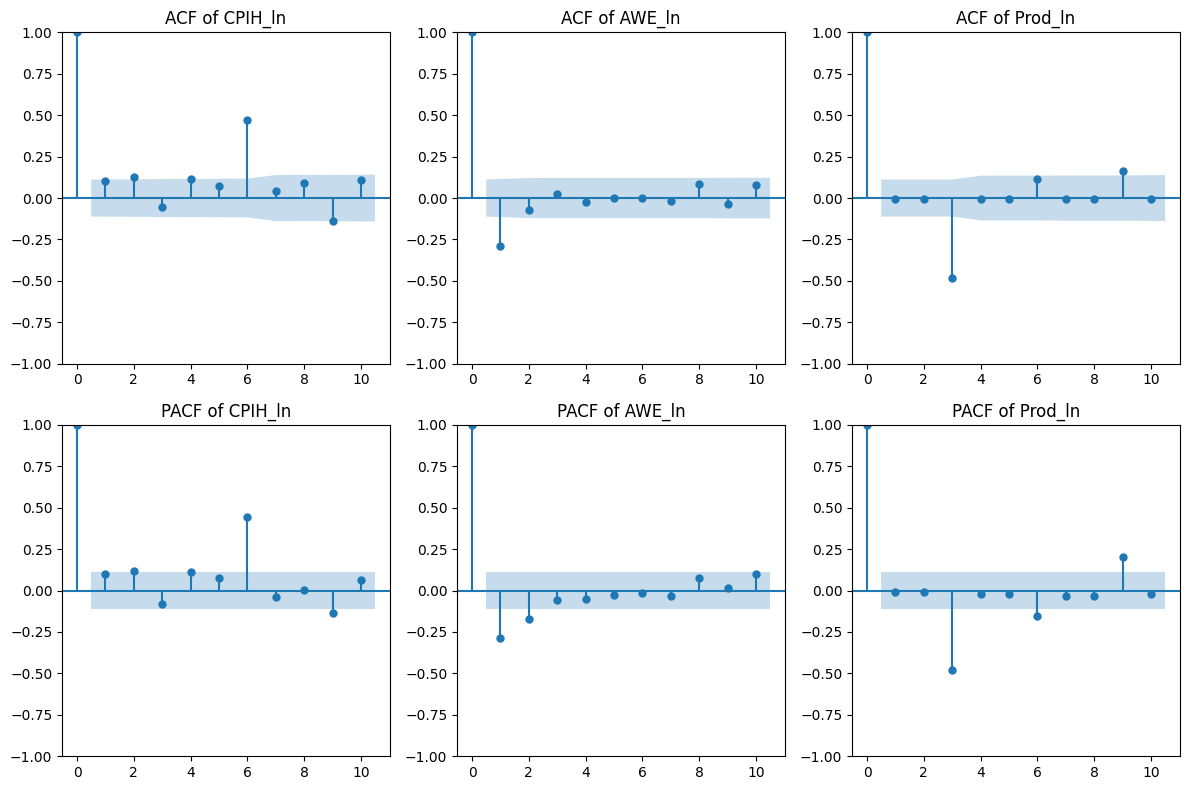

In [52]:
# Setting up plot
fig, axes = plt.subplots(2,3, figsize=(12,8))

for i, col in enumerate(cols):
    # ACF plot with 10 lags - 1st difference
    plot_acf(df_log_diff[col], lags=10, ax=axes[0,i])
    axes[0,i].set_title(f"ACF of {col}")

    # PACF plot with 10 lags
    plot_pacf(df_log_diff[col], lags=10, method="ywm", ax=axes[1,i])
    axes[1,i].set_title(f"PACF of {col}")

plt.tight_layout()
plt.show()


No evidence for high lag orders. No reason to add second or higher differences

In [53]:
# Testing for Co-Integration
# Cointegration rank is sum of trace statistics with greater than 5% crit values

# Copying df
joh_data = df_log[cols]

# Running test and iterating over lag length
for lag in range(1,5):
    johansen_test = coint_johansen(joh_data, det_order=0, k_ar_diff=lag)
    # Taking trace statistics
    trace_stats = johansen_test.lr1
    # Taking critical values
    crit_val_5 = johansen_test.cvt[:, 1]
    # Summing conditional
    rank = np.sum(trace_stats > crit_val_5)
    print(f"Lags {lag} --> Cointegration Rank {rank}")

# Estimated cointegration rank is 2
# With 3 variables -> 2 indep. stationary long-run trends, 1 common stochastic trend

Lags 1 --> Cointegration Rank 2
Lags 2 --> Cointegration Rank 2
Lags 3 --> Cointegration Rank 0
Lags 4 --> Cointegration Rank 0


Cointegration rank 2. We choose VECM over VAR

In [54]:
# Choosing lag length with VAR lag criterion
lag_order = VAR(joh_data).select_order(10)
print(lag_order.summary())
# AIC picks 7, BIC picks 1. We ahev VAR(2) and p-1=1 for VECM

# Creating VECM model with VAR(2) = p-1 and cointegration rank 2
vecm_model = VECM(joh_data, k_ar_diff=1, coint_rank=2, deterministic="co").fit()
print(vecm_model.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -18.88      -18.84   6.334e-09      -18.86
1       -30.82     -30.67*   4.138e-14      -30.76
2       -30.84      -30.58   4.026e-14      -30.74
3       -30.85      -30.47   4.017e-14      -30.70
4       -31.07      -30.58   3.221e-14      -30.87
5       -31.06      -30.46   3.244e-14      -30.82
6       -31.04      -30.34   3.300e-14      -30.76
7      -31.27*      -30.45  2.623e-14*     -30.94*
8       -31.23      -30.30   2.747e-14      -30.85
9       -31.21      -30.17   2.785e-14      -30.80
10      -31.26      -30.10   2.671e-14      -30.79
--------------------------------------------------
Det. terms outside the coint. relation & lagged endog. parameters for equation CPIH_ln
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

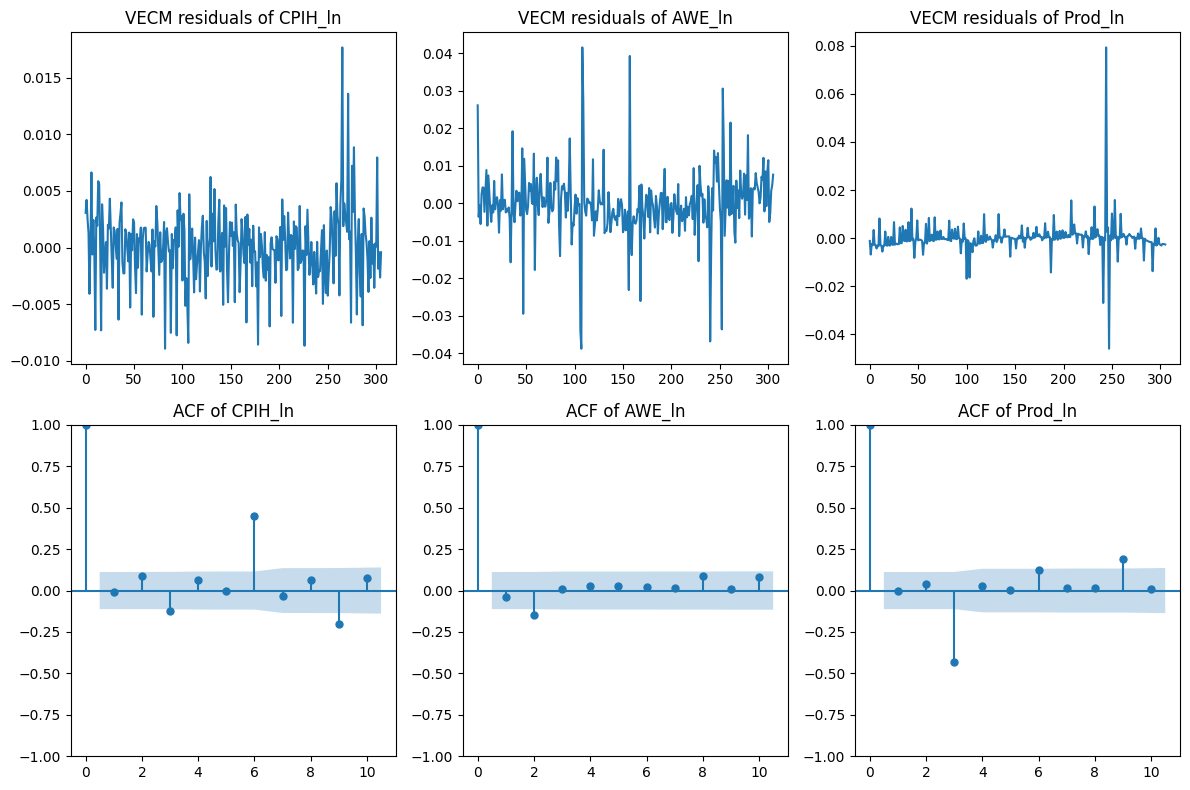

In [55]:
# Plotting residuals
resid = vecm_model.resid
cols_resid = joh_data.columns

# Setting up subplot
fig, axes = plt.subplots(2,3, figsize=(12,8))

# Iterating over index and column label
for i, col in enumerate(cols_resid):
    # Defining top row
    t_row = axes[0, i]

    # Residuals time series
    t_row.plot(resid[:, i])
    t_row.set_title(f"VECM residuals of {col}")

    # ACF plots of residuals
    plot_acf(resid[:, i], lags=10, ax=axes[1,i])
    axes[1,i].set_title(f"ACF of {col}")

plt.tight_layout()
plt.show()


In [56]:
# Testing with white's test
print(vecm_model.test_whiteness(nlags=10))
# Reject the null, residual autocorrelation is significant
# We run again with VAR(3)

vecm_model_2 = VECM(joh_data, k_ar_diff=2, coint_rank=2, deterministic="co").fit()
print(vecm_model_2.test_whiteness(nlags=10))

vecm_model_3 = VECM(joh_data, k_ar_diff=3, coint_rank=2, deterministic="co").fit()
print(vecm_model_3.test_whiteness(nlags=10))

vecm_model_4 = VECM(joh_data, k_ar_diff=4, coint_rank=2, deterministic="co").fit()
print(vecm_model_4.test_whiteness(nlags=10))

# Test statistics is falling. VAR(5) is probably overfitting, use VAR(4) so vecm_model_3
# Make into loop

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 230.986, critical value: 96.217>, p-value: 0.000>
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 212.395, critical value: 85.965>, p-value: 0.000>
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 138.636, critical value: 75.624>, p-value: 0.000>
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 122.131, critical value: 65.171>, p-value: 0.000>


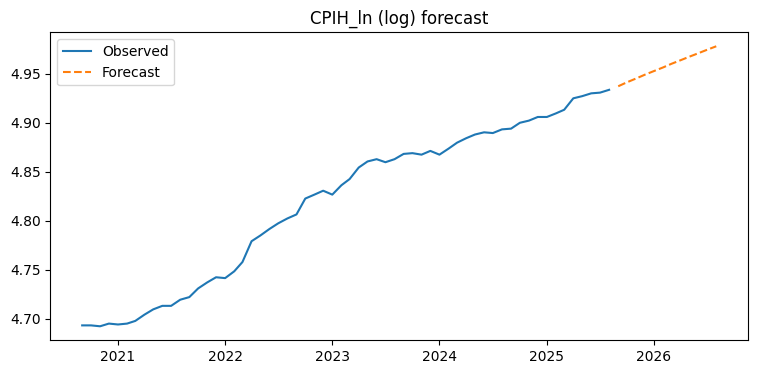

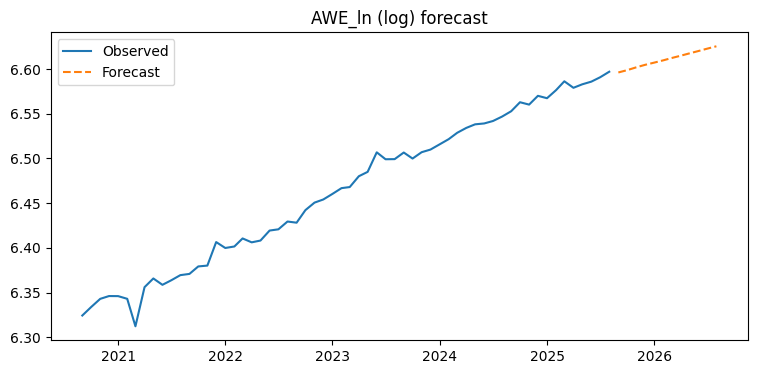

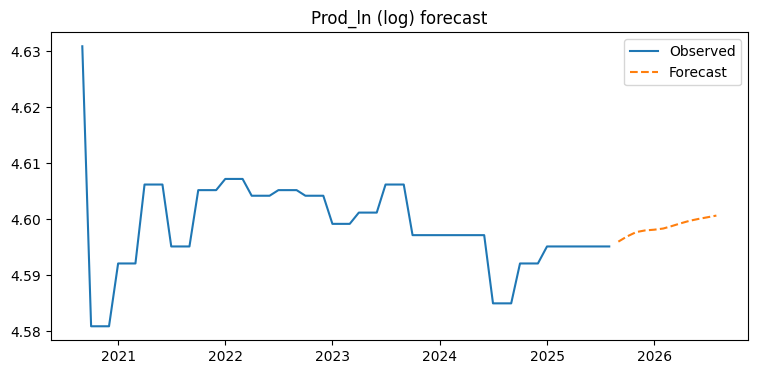

In [65]:
# Forecasting
forecast_1year = vecm_model_3.predict(steps=12)

# Constructing index
fore_year_index = pd.date_range(
    start=joh_data.index[-1],
    periods=13,
    freq=joh_data.index.freq
)[1:]

# Wrapping into dataframe
fore_year_df = pd.DataFrame(
    forecast_1year,
    index=fore_year_index,
    columns=joh_data.columns
)

# Setting cutoff point to be the last 5 years
cutoff = joh_data.index[-60]

# Plotting observed and predicted
for col in joh_data.columns:
    plt.figure(figsize=(9,4))
    plt.plot(joh_data.loc[cutoff:,col], label="Observed")
    plt.plot(fore_year_df[col], linestyle="--", label="Forecast")
    plt.title(f"{col} (log) forecast")
    plt.legend()
    plt.show()

In [73]:
# Pseudo out-of-sample prediction
in_sample = "2017-04-06"

# Splitting into training and test data
train = joh_data.loc[:in_sample]
# Test data stops after 12 months
test = joh_data.loc[in_sample:].iloc[:12]

# VECM with VAR(4) on training
vecm_train = VECM(train, k_ar_diff=3, coint_rank=2, deterministic="co").fit()

# Forecasting
forecast_test = vecm_train.predict(steps=12)

# Converting into df
forecast_test_df = pd.DataFrame(
    forecast_test,
    index=test.index,
    columns=joh_data.columns
)

# Calculating RMSE
for col in cols:
    rmse = np.sqrt(
        np.mean((forecast_test_df[col] - test[col]) ** 2)
    )
    print(f"RMSE for {col} is {rmse: .4f} -- {rmse*100: .2f}% level error")

RMSE for CPIH_ln is  0.0023 --  0.23% level error
RMSE for AWE_ln is  0.0046 --  0.46% level error
RMSE for Prod_ln is  0.0121 --  1.21% level error
